In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# !pip install pytorch_lightning
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import time
from datetime import datetime
from dateutil.tz import gettz
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.set_per_process_memory_fraction(0.3, 0)
torch.cuda.empty_cache()

### Define Model

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

## Define Model
class simpleVAE(nn.Module):
    def __init__(self,in_channels,latent_dim):
        super(simpleVAE,self).__init__()
        self.latent_dim = latent_dim
        ##encoder
        Modules = []
#         self.hidden_dim = [8,16,16,32,64]
        self.hidden_dim = [16,32,64,128,256]
        for channel in self.hidden_dim:
            Modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels,channel,3,stride=2,padding=1),
                nn.BatchNorm2d(channel),
                nn.LeakyReLU()
            )
            )
            in_channels = channel

        self.encoder = nn.Sequential(*Modules)
        
        self.fc_mu = nn.Linear(in_channels*4,latent_dim)
        self.fc_logvar = nn.Linear(in_channels*4,latent_dim)
        
        Modules = []
        self.decoder_input = nn.Linear(latent_dim,in_channels*4)
        
        for channel in self.hidden_dim[::-1][1:]:
            Modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(in_channels,channel,3,stride=2,padding=1,output_padding=1),
                nn.BatchNorm2d(channel),
                nn.LeakyReLU()
            )
            )
            in_channels = channel
        
        Modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(self.hidden_dim[0],3,3,stride=2,padding=1,output_padding=1),
                nn.Sigmoid()
            )
        ) 
        self.decoder = nn.Sequential(*Modules)
        
    def forward_encode(self,x):
        x = self.encoder(x)
        x = torch.flatten(x,start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return [mu,logvar]
    
    def forward_decode(self,x):
        x = self.decoder_input(x)
        x = x.view(-1,self.hidden_dim[-1],2,2)
        x = self.decoder(x)
        return x
    
    def reparametrize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps*std + mu
    
    def forward(self,x):
        mu,logvar = self.forward_encode(x)
        z = self.reparametrize(mu,logvar)
        return [self.forward_decode(z), x, mu, logvar]
    
    def loss_fn(self,recons,x,mu,logvar,kld_weight=0.00025):
        mse_loss = torch.nn.functional.mse_loss(recons,x)
        kld_loss = torch.mean(-0.5* torch.sum(1 + logvar - mu**2 - logvar.exp(),dim=1),dim=0)
        loss = mse_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':mse_loss.detach(), 'KLD':-(kld_loss*kld_weight).detach()}        
    
    def sample(self,num_samples):
        z = torch.randn(num_samples,self.latent_dim)
        z = z.to(device)
        samples = self.forward_decode(z)
        return samples

cuda


### Train & Test Functions

In [ ]:
def train_model(model,dataloader,optimizer):
    num_batches = len(dataloader)
    train_loss = {}

    for batch, (X,y) in enumerate(dataloader):
        recons,X,mu,logvar = model(X.to(device))
        loss = model.loss_fn(recons,X,mu,logvar,kld_weight)

        ##backpropagation
        optimizer.zero_grad()
        loss["loss"].backward()
        optimizer.step()

        if batch%20 == 0:

            print("Loss [Batch No:" + str(batch) + "]:",
                  loss["loss"].to("cpu").detach().numpy()," Reconstruction loss:", 
                  loss["Reconstruction_Loss"].to("cpu").detach().numpy(),
            " KLD Loss", loss["KLD"].to("cpu").detach().numpy()
            )


        if len(train_loss.items()) == 0:
            train_loss = loss
        else:
            for k,v in loss.items():
                train_loss[k] = train_loss[k] + v

    for k,v in train_loss.items():
        train_loss[k] = v/num_batches          
    

    return train_loss

def test_model(model,dataloader):
    num_batches = len(dataloader)
    test_loss = {}

    with torch.no_grad():
        for X, y in dataloader:
            recons,X,mu,logvar = model(X.to(device))
            loss = model.loss_fn(recons,X,mu,logvar,kld_weight)
            if len(test_loss.items()) == 0:
                test_loss = loss
            else:
                for k,v in loss.items():
                    test_loss[k] = test_loss[k] + v

    for k,v in test_loss.items():
        test_loss[k] = v/num_batches          

    return test_loss

### Dataloader

In [61]:
input_shape = (3,64,64)
batch_size = 100

data_transforms = transforms.Compose([
                                    transforms.Resize(input_shape[1:]),
                                    transforms.ToTensor(),
                                ])
path = ""
train_dataset = datasets.CelebA(root=path + "data/",split="train",transform=data_transforms,download=False)
test_dataset = datasets.CelebA(root=path + "data/",split="test",transform=data_transforms,download=False)

train_dataloader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True,num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)

### Initialize parameters

In [71]:
## Get model
input_shape = (3,64,64)
latent_dim = 512

## Define model
model = simpleVAE(input_shape[0],latent_dim)
print(summary(model.to(device),input_shape))

## Hyperparameter
learning_rate = 1e-3
epochs = 20
kld_weight = 1

## Define Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

## Define Logger
expt_name = "l_dim_" + str(latent_dim) + "_l_r_" + str(learning_rate) + "_kld_w_" + str(kld_weight)
logdir = expt_name + "/" + datetime.now(tz=gettz('Asia/Kolkata')).strftime("%d_%b_%H_%M")
writer = SummaryWriter(path + "logs/" + logdir)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         LeakyReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
      BatchNorm2d-11            [-1, 128, 4, 4]             256
        LeakyReLU-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 2, 2]         295,168
      BatchNorm2d-14            [-1, 25

### Train Model

In [ ]:
for epoch in range(epochs):
    print("Epoch ",epoch)
    train_loss = train_model(model,train_dataloader,optimizer)
    test_loss = test_model(model,test_dataloader)
    for k,v in train_loss.items():
        writer.add_scalars(k,{'train_' + k:v,'test_' + k:test_loss[k]},epoch)
    x_test = iter(test_dataloader).next()
    z = model.forward(x_test[0].to(device))
    recons = z[0].detach().to("cpu").numpy()
    org = z[1].detach().to("cpu").numpy()
    plt.figure(figsize=(20,20))
    for i in range(0,100,2):
        plt.subplot(10,10,i+1)
        plt.imshow(np.transpose(recons[i],(1,2,0)))
        plt.subplot(10,10,i+2)
        plt.imshow(np.transpose(org[i],(1,2,0)))
    plt.show()
torch.save(model,"logs/" + logdir+"/model.pth")

### Sample the models and view outputs

In [66]:
model = torch.load("logs/l_dim_512_l_r_0.001_kld_w_0.00025/06_Oct_09_52/model.pth")

In [67]:
x_test = iter(test_dataloader).next()
z = model.forward(x_test[0].to(device))
recons = z[0].detach().to("cpu").numpy()
org = z[1].detach().to("cpu").numpy()

<Figure size 640x480 with 0 Axes>

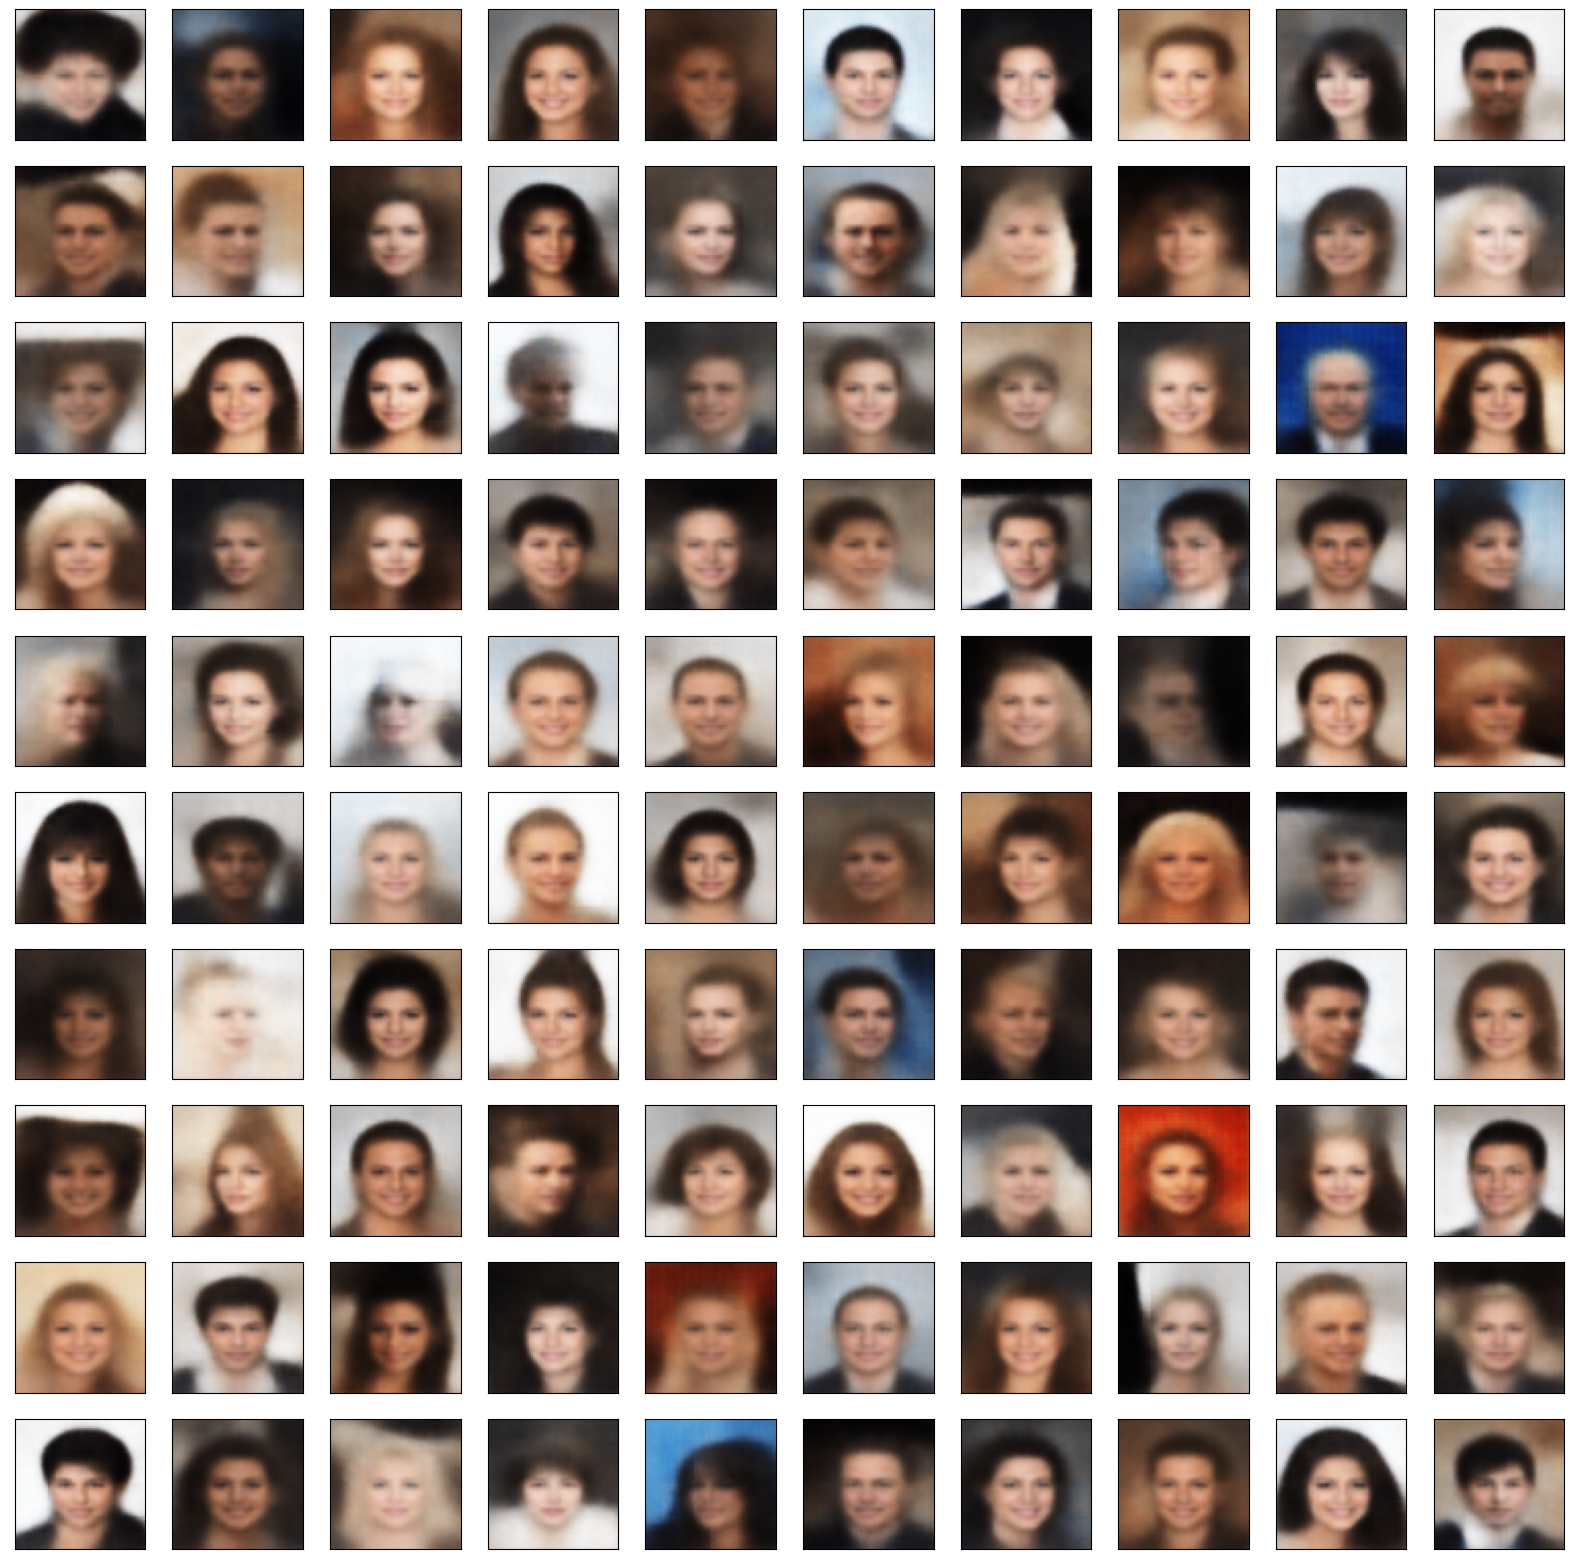

In [68]:
plt.figure(figsize=(20,20))
for i in range(0,100,1):
    plt.subplot(10,10,i+1)
    plt.imshow(np.transpose(recons[i],(1,2,0)))
    plt.xticks([])
    plt.yticks([])
#     plt.subplot(10,10,i+2)
#     plt.imshow(np.transpose(org[i],(1,2,0)))
#     plt.xticks([])
#     plt.yticks([])
# fig.suptitle("Latent dim = 512")
plt.show()
plt.savefig("samples_512.png")

### Sampling using gradient based mcmc

In [5]:
import hamiltorch
from scipy.stats import norm, gaussian_kde
from scipy.special import logsumexp

In [26]:
def log_prob_z_x(z):
    ## logprob(x/z) ~ gaussian N(X;Xpred,I), logprob(z) ~ N(O,I), constants are ignored, as only derivatives are needed. 
    pred = model.forward_decode(z)
    log_prob_x_z = torch.nn.functional.mse_loss(pred,x_true)
    log_prob_z = z**2
    log_prob_z_x = torch.sum(-0.5 * (log_prob_x_z + log_prob_z))
    return log_prob_z_x

## Sample from mcmc
def sample_from_mcmc(log_prob_z_x,initial_z,num_samples,step_size):
    num_steps_per_sample = 4
    params_init = initial_z
    z_samples = hamiltorch.sample(log_prob_func=log_prob_z_x, params_init=initial_z,  
                                   num_samples=num_samples, step_size=step_size, 
                                   num_steps_per_sample=num_steps_per_sample)
    return z_samples

## Computing log likelihood
def log_likelihood(model,x_test):
    likelihood = []
    mu,logvar = model.forward_encode(x_test.to(device))
    z = model.reparametrize(mu,logvar)    
    for k in range(len(x_test)):
        global x_true
        
        ## for single datapoint
        x_true = x_test[k].to(device)
        init_z = z[k]
        num_samples = 50
        step_size = 0.03
        plt.figure()
        plt.subplot(121)
        plt.imshow(np.transpose(x_true.detach().to("cpu").numpy(),(1,2,0)))

        ## step 1: sampling from gradint hamilton mcmc
        z_samples = sample_from_mcmc(log_prob_z_x,init_z,num_samples,step_size)
        z_samples_np = np.array([z_samples[i].detach().to("cpu").numpy() for i in range(len(z_samples))])

        ## step 2: difficult to fit density for latent dim=512, so assumping gaussian density with known parameters mu, logvar
        sample_mu = mu[k].detach().to("cpu").numpy()
        sample_logvar = logvar[k].detach().to("cpu").numpy()

        ## step3 : estimating q(z),p(z) with same sampling
        q_z = np.array([norm.pdf(z_samples_np[:,index],loc=sample_mu[index],
                                 scale = np.exp(sample_logvar[index])) for index in range(z_samples_np.shape[1])]).T
        p_z = np.array([norm.pdf(z_samples_np[:,index]) for index in range(z_samples_np.shape[1])]).T
        q_z = np.clip(p_z, np.finfo(float).eps, None)
        p_z = np.clip(q_z, np.finfo(float).eps, None)

        ## Log likelihood computation for L samples of single datapoint
        pred = model.forward_decode(torch.stack(z_samples))
        plt.subplot(122)
        plt.imshow(np.transpose(pred[0].detach().to("cpu").numpy(),(1,2,0)))
        plt.show()
        logp_x_z = (- (np.prod(pred.shape[1:])/2) * np.log(2*np.pi)) - 0.5 * torch.sum(torch.nn.functional.mse_loss(pred,torch.broadcast_to(x_true,pred.shape),
                                                          reduction='none'),axis = [1,2,3]).detach().to("cpu").numpy()
        logpz = np.sum(np.log(p_z), axis=-1)
        logqz = np.sum(np.log(q_z), axis=-1)
        argsum =  logqz - logp_x_z - logpz 
        logpx = np.log(num_samples) - logsumexp(argsum)
        likelihood.append(logpx)
    return likelihood

In [ ]:
likelihood = []
model = torch.load("logs/l_dim_128_l_r_0.001_kld_w_0.00025/06_Oct_00_48/model.pth")
# model = torch.load("logs/l_dim_512_l_r_0.001_kld_w_0.00025/06_Oct_09_52/model.pth")
for batch, (x_test,y) in enumerate(test_dataloader):
    likelihood.extend(log_likelihood(model,x_test))
    if batch == 10:
        break
print("Likelihood",np.mean(likelihood))